In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import heapq  # Для приоритетной очереди в A*

Создаем карту препятствий

In [62]:
map_size = 10.0
start = (1.0, 1.0)
goal = (9.0, 9.0)

# Препятствия, как список кортежей (x, y, radius)
obstacles_0 = [
    (5, 5, 0.6)
]


obstacles_1 = [
    (8, 8, 0.55),
    (2.2, 2.2, 0.7),
    (8.5, 5.5, 0.5),
    (5.8, 5.0, 0.7),
    (3.5, 4.8, 0.5),
    (6.0, 7.0, 0.4)
]


obstacles_2 = [
    (8, 8, 0.55),
    (2.2, 2.2, 0.7),
    (8.5, 5.5, 0.5),
    (5.8, 5.0, 0.7),
    (3.5, 4.8, 0.5),
    (6.0, 7.0, 0.4),
    (4.0, 6.0, 0.5),
    (7.0, 3.0, 0.5),
    (6.8, 8.0, 0.5),
    (4.0, 3.0, 0.5),
    (5.0, 7.5, 0.5),
    (2.0, 6.0, 0.7),
    (7.0, 6.5, 0.5),
    (2.5, 3.7, 0.5)
]

obstacles = obstacles_1

# Дискретизация сетки
grid_resolution = 0.25  # Шаг сетки
grid_size = int(map_size / grid_resolution) + 1 
grid = np.zeros((grid_size, grid_size), dtype=bool)  # False - свободно, True - занято

# Проверка пересечений
def is_obstacle(x, y, obstacles, extra_radius=0.0):
    for ox, oy, orad in obstacles:
        dist = np.sqrt((x - ox)**2 + (y - oy)**2)
        if dist <= orad + extra_radius:
            return True
    return False


for i in range(grid_size):
    for j in range(grid_size):
        x = i * grid_resolution
        y = j * grid_resolution
        if is_obstacle(x, y, obstacles, 0.0):
            grid[i, j] = True

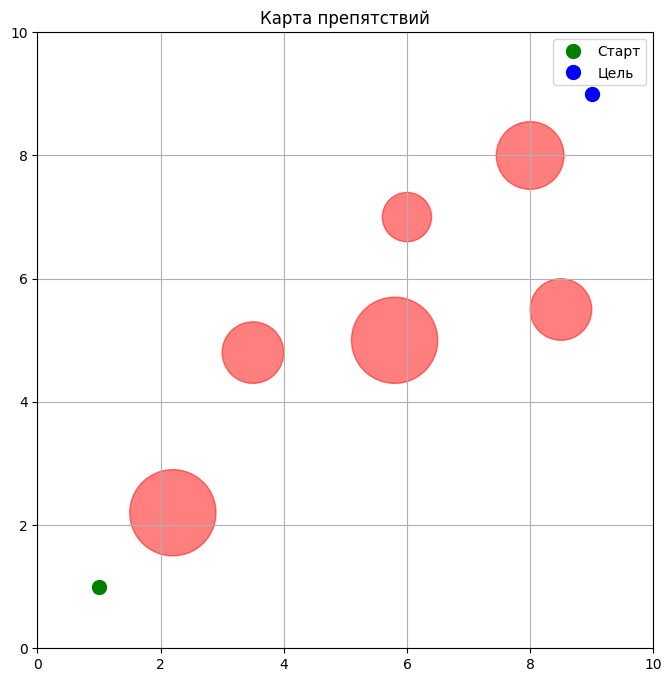

In [63]:
# График карты препятствий
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, map_size)
ax.set_ylim(0, map_size)
ax.set_aspect('equal')
ax.set_title('Карта препятствий')
ax.grid(True)

for x_o, y_o, r in obstacles:
    circle = plt.Circle((x_o, y_o), r, color='red', alpha=0.5)
    ax.add_patch(circle)

# Старт и цель
ax.plot(start[0], start[1], 'go', markersize=10, label='Старт')
ax.plot(goal[0], goal[1], 'bo', markersize=10, label='Цель')

ax.legend()
plt.savefig(f'map.png', dpi=150)
plt.show()

Функция нахождения траектории по алгоритму A*

In [64]:
def a_star(start, goal, grid, resolution):
    start_grid = (int(start[0] / resolution), int(start[1] / resolution))
    goal_grid = (int(goal[0] / resolution), int(goal[1] / resolution))
    
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (1,1), (1,-1), (-1,1), (-1,-1)]  # 8 соседей
    
    open_set = []
    heapq.heappush(open_set, (0, start_grid))  # (priority, position)
    came_from = {}
    g_score = {start_grid: 0}
    f_score = {start_grid: np.sqrt((goal_grid[0] - start_grid[0])**2 + (goal_grid[1] - start_grid[1])**2)}  # Евклидова
    
    while open_set:
        current = heapq.heappop(open_set)[1]
        if current == goal_grid:
            # Реконструируем путь
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start_grid)
            path.reverse()
            # Конвертируем в реальные координаты (центр клетки)
            return [(x * resolution, y * resolution) for x, y in path]
        
        for dx, dy in directions:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < grid_size and 0 <= neighbor[1] < grid_size and not grid[neighbor[0], neighbor[1]]:
                cost = np.sqrt(dx**2 + dy**2)  # 1 для прямых, sqrt(2) для диагоналей
                tentative_g = g_score[current] + cost
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score[neighbor] = tentative_g + np.sqrt((goal_grid[0] - neighbor[0])**2 + (goal_grid[1] - neighbor[1])**2)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
    
    return None  # Если путь не найден


Находим A* путь, интерполируем кубическим B-сплайном, смотрим на результат

Длина пути A*: 12.19 м
Количество точек в A*: 39


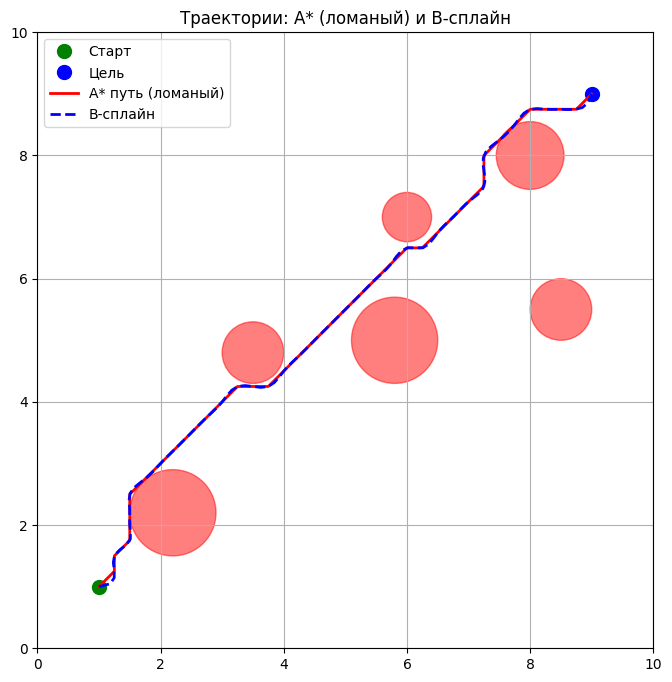

In [65]:
path_a_star = a_star(start, goal, grid, grid_resolution)
if path_a_star is None:
    raise ValueError("Путь не найден! Проверьте карту.")

# Интерполяция B-сплайном
x_a, y_a = zip(*path_a_star)
tck, u = splprep([x_a, y_a], s=0, k=3)
u_new = np.linspace(0, 1, 100)
x_spline, y_spline = splev(u_new, tck)

# Длина пути A*
path_length_a = sum(np.sqrt((path_a_star[i+1][0] - path_a_star[i][0])**2 + (path_a_star[i+1][1] - path_a_star[i][1])**2) for i in range(len(path_a_star)-1))
print(f"Длина пути A*: {path_length_a:.2f} м")
print(f"Количество точек в A*: {len(path_a_star)}")

# График
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, map_size)
ax.set_ylim(0, map_size)
ax.set_aspect('equal')
ax.set_title('Траектории: A* (ломаный) и B-сплайн')
ax.grid(True)

# Препятствия
for x_o, y_o, r in obstacles:
    circle = plt.Circle((x_o, y_o), r, color='red', alpha=0.5)
    ax.add_patch(circle)

# Старт и цель
ax.plot(start[0], start[1], 'go', markersize=10, label='Старт')
ax.plot(goal[0], goal[1], 'bo', markersize=10, label='Цель')

# Пути
ax.plot(x_a, y_a, 'r-', linewidth=2, label='A* путь (ломаный)')
ax.plot(x_spline, y_spline, 'b--', linewidth=2, label='B-сплайн')

ax.legend()
plt.savefig(f'Base_path.png', dpi=150)
plt.show()

Простое сглаживание B сплайном не подходит для чистого использования в планировании пути, так как возникают пересечения

Создаем функции для подсчета критериев качества - длина, кривизна, расстояние до препятствия.

In [66]:
def compute_path_length(x, y):
    return np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))


def compute_curvature(x, y):
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2 + 1e-6)**1.5
    return np.mean(curvature)


def compute_obstacle_cost(x, y, obstacles):
    cost = 0.0
    for xi, yi in zip(x, y):
        min_dist = np.inf
        for ox, oy, r in obstacles:
            dist = np.sqrt((xi - ox)**2 + (yi - oy)**2) - r
            min_dist = min(min_dist, dist)

        if min_dist < 0.2:
            cost += (0.2 - min_dist)**2
    return cost

Рассчитываем значение функции критериев качества. Особый вес уделяем расстоянию до препятствий, так как столкновения - дорогая ошибка

In [67]:
def objective(ctrl_points_flat):
    ctrl_points = ctrl_points_flat.reshape(-1, 2)

    # фиксируем старт и финиш
    ctrl_points[0] = start
    ctrl_points[-1] = goal

    x_ctrl = ctrl_points[:, 0]
    y_ctrl = ctrl_points[:, 1]

    tck, _ = splprep([x_ctrl, y_ctrl], s=0, k=3)
    u_new = np.linspace(0, 1, 100)
    x_s, y_s = splev(u_new, tck)

    L = compute_path_length(x_s, y_s)
    C = compute_curvature(x_s, y_s)
    O = compute_obstacle_cost(x_s, y_s, obstacles)

    w1, w2, w3 = 3.0, 5.0, 10.0

    return w1*L + w2*C + w3*O


Оптимизируем функцию по ключевым точкам A* траектории, берем 12 точек и используем 100 циклов для прогона. В звисимости от сложности карты, в реальной ситуации можно использовать и 10, скорость инференса сокращается в 9 раз, а качество не падает до критических значений и все еще удовлетворяет условиям

In [68]:
from scipy.optimize import minimize

# ctrl_points_init = np.array(path_a_star)
indices = np.linspace(0, len(path_a_star)-1, 12).astype(int)
ctrl_points_init = np.array(path_a_star)[indices]

result = minimize(
    objective,
    ctrl_points_init.flatten(),
    method='SLSQP',
    options={'maxiter': 100, 'disp': True}
)

ctrl_opt = result.x.reshape(-1, 2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 37.14811366417651
            Iterations: 90
            Function evaluations: 2345
            Gradient evaluations: 90


In [69]:
x_ctrl_opt = ctrl_opt[:, 0]
y_ctrl_opt = ctrl_opt[:, 1]

tck_opt, _ = splprep([x_ctrl_opt, y_ctrl_opt], s=0, k=3)
u_new = np.linspace(0, 1, 200)
x_opt, y_opt = splev(u_new, tck_opt)


In [70]:
L_before = compute_path_length(x_spline, y_spline)
C_before = compute_curvature(x_spline, y_spline)
O_before = compute_obstacle_cost(x_spline, y_spline, obstacles)

L_after = compute_path_length(x_opt, y_opt)
C_after = compute_curvature(x_opt, y_opt)
O_after = compute_obstacle_cost(x_opt, y_opt, obstacles)

print("\n=== МЕТРИКИ ===")
print("До оптимизации:")
print(f"Длина: {L_before:.3f}")
print(f"Кривизна: {C_before:.3f}")
print(f"Obstacle cost: {O_before:.3f}")

print("\nПосле оптимизации:")
print(f"Длина: {L_after:.3f}")
print(f"Кривизизна: {C_after:.3f}")
print(f"Obstacle cost: {O_after:.3f}")



=== МЕТРИКИ ===
До оптимизации:
Длина: 12.326
Кривизна: 1.031
Obstacle cost: 0.666

После оптимизации:
Длина: 11.915
Кривизизна: 0.247
Obstacle cost: 0.038


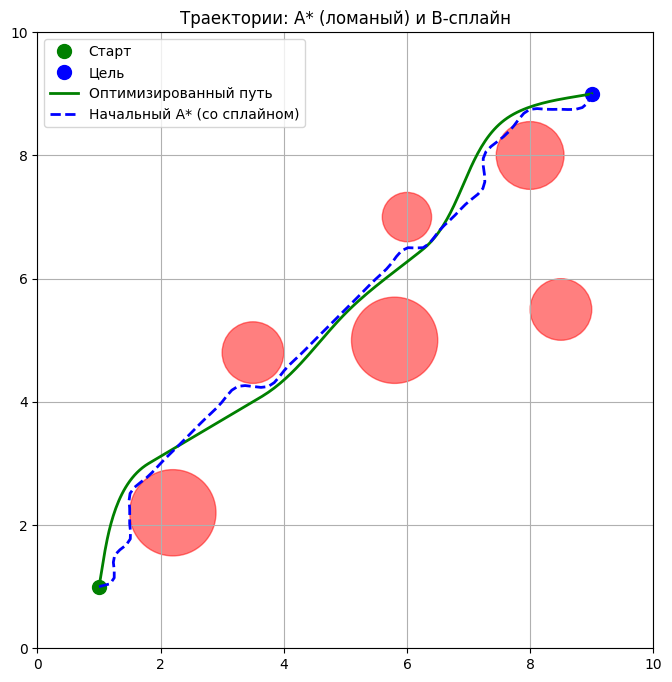

In [71]:
# График
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, map_size)
ax.set_ylim(0, map_size)
ax.set_aspect('equal')
ax.set_title('Траектории: A* (ломаный) и B-сплайн')
ax.grid(True)

# Препятствия (без расширения)
for x_o, y_o, r in obstacles:
    circle = plt.Circle((x_o, y_o), r, color='red', alpha=0.5)
    ax.add_patch(circle)

# Старт и цель
ax.plot(start[0], start[1], 'go', markersize=10, label='Старт')
ax.plot(goal[0], goal[1], 'bo', markersize=10, label='Цель')

# Путь A*
ax.plot(x_opt, y_opt, 'g-', linewidth=2, label='Оптимизированный путь')

# Сплайн
ax.plot(x_spline, y_spline, 'b--', linewidth=2, label='Начальный A* (со сплайном)')

ax.legend()
plt.savefig(f'Optimized_path.png', dpi=150)
plt.show()

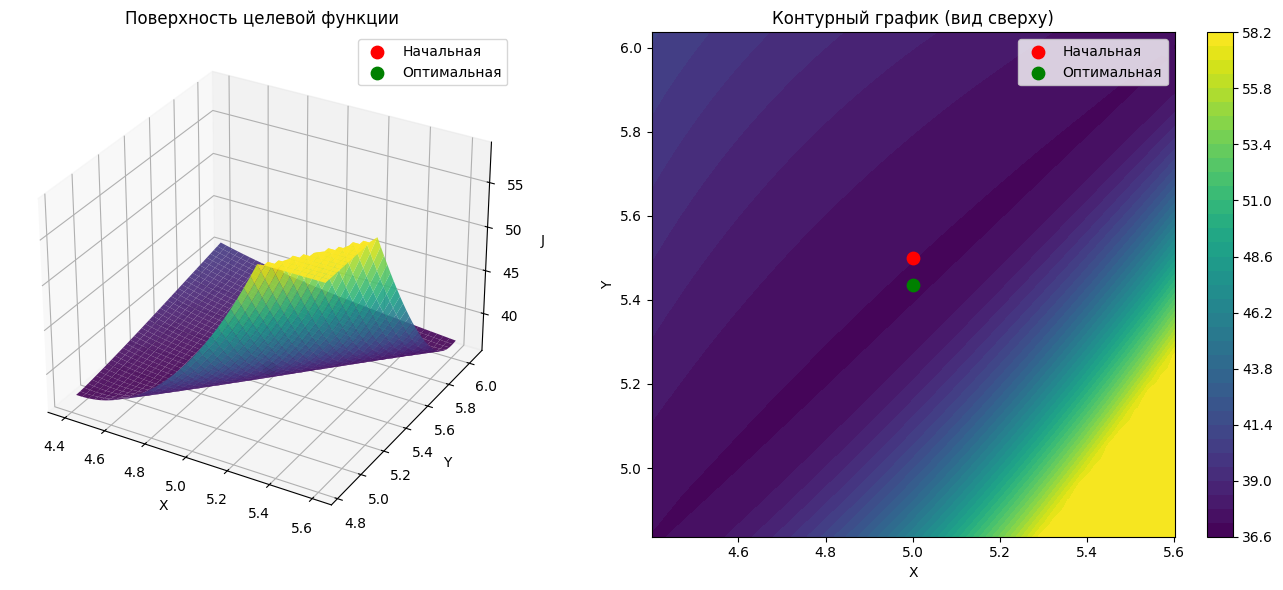

In [72]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Индекс варьируемой контрольной точки
mid_idx = len(ctrl_points_init)//2

# Берем оптимизированные точки как центр
base_ctrl = ctrl_opt.copy()

delta = 0.6

x_center = base_ctrl[mid_idx, 0]
y_center = base_ctrl[mid_idx, 1]

x_range = np.linspace(x_center - delta, x_center + delta, 40)
y_range = np.linspace(y_center - delta, y_center + delta, 40)

X, Y = np.meshgrid(x_range, y_range)
Z = np.zeros_like(X)

# ===== Вычисление поверхности =====
for i in range(len(x_range)):
    for j in range(len(y_range)):
        test_ctrl = base_ctrl.copy()
        test_ctrl[mid_idx] = [X[j, i], Y[j, i]]

        try:
            Z[j, i] = objective(test_ctrl.flatten())
        except:
            Z[j, i] = np.nan  # если сплайн не строится

Z = np.nan_to_num(Z, nan=np.nanmax(Z))

z_clip = np.percentile(Z, 95)
Z_vis = np.clip(Z, None, z_clip)

# ===== Визуализация =====
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z_vis, cmap='viridis', alpha=0.9)

# Начальная точка
J_start = objective(ctrl_points_init.flatten())
ax1.scatter(ctrl_points_init[mid_idx, 0],
            ctrl_points_init[mid_idx, 1],
            J_start,
            color='red', s=80, label='Начальная')

# Оптимальная точка
J_opt = objective(ctrl_opt.flatten())
ax1.scatter(ctrl_opt[mid_idx, 0],
            ctrl_opt[mid_idx, 1],
            J_opt,
            color='green', s=80, label='Оптимальная')

ax1.set_title("Поверхность целевой функции")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("J")
ax1.legend()

# --- Вид сверху ---
ax2 = fig.add_subplot(122)
cont = ax2.contourf(X, Y, Z_vis, levels=40, cmap='viridis')
plt.colorbar(cont, ax=ax2)

ax2.scatter(ctrl_points_init[mid_idx, 0],
            ctrl_points_init[mid_idx, 1],
            color='red', s=80, label='Начальная')

ax2.scatter(ctrl_opt[mid_idx, 0],
            ctrl_opt[mid_idx, 1],
            color='green', s=80, label='Оптимальная')

ax2.set_title("Контурный график (вид сверху)")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.legend()

plt.savefig(f'optim_func.png', dpi=150)
plt.tight_layout()
plt.show()